# MDX Food Safety Hackathon

This github repository can also be viewed online via the [Jupyter notebook viewer](https://nbviewer.jupyter.org/github/aastha12/MDX-Food-Safety-Hackathon/tree/master/) incase the GitHub renderer filters any sections out.

## Table of Contents <a id='TOC'></a>

1. [Introduction](#intro) 


2. [Data Loading](#DL) 


3. [Analysis](#Analysis) 

    3.1 [Part 1: Exploratory Data Analysis (EDA)](#EDA)

    3.2 [Part 2: Logistic Regression](#logregr) 

    3.3 [Part 3: Automate sending alert cases as whatsapp messages](#whatsapp) 

    3.4 [Part 4: Deploying the Logistic Regression model to a web app](#web) 

## 1. Introduction <a id='intro'></a>

Every year almost 1 in 10 people in the world fall ill from consuming contaminated food. Unsafe food poses global health threats for everyone especially infants, young children, pregnant women, the elderly, and those with an underlying illness. The importance of food safety can be understood from the fact that foodborne illness hinders socioeconomic development by straining health care systems, and harming national economies, tourism and trade. Unsafe food creates a vicious cycle of disease and malnutrition. Hence, it is clear that food safety, nutrition and sustainable economic development are inextricably linked. It becomes crucial for us to improve the current food safety measures to not only reduce foodborne illness but also improve the economic and social background.

To play a part in improving the current food safety measures, Middlesex University has collaborated with RUBICS Smart Solutions, DataCon Dubai 2020 and Beinex to organize the “Analytics for Food Safety Hackathon” where the objective of the hackathon is quite open ended yet gives us a chance to be creative – come up with innovative and sustainable solutions to improve the food safety measures.


<img src="https://ci6.googleusercontent.com/proxy/QNvuaLryENDmCgsofLUQn6q1_PVARKPbznEPJka8Ubqllox_ABArytNnYOwxZ7KZVDQlEo87SuoMAwkppPaqjwNhjGVifIrP2jcrMq_OR5whOGiFmx84N7zGnNkuXCEQasleoaJ0W7rYlpvLllzG6I2OyVp0Lw=s0-d-e1-ft#https://mcusercontent.com/3d7b040432dd70c5a71205589/images/189e584d-327f-4ac0-b6ae-84f679a99e44.png" width="500">

## 2. Data Loading <a id='DL'></a>

As part of the hackathon, we were provided with 10 csv files:
1.	AlertLevel
2.	Attribute
3.	Date
4.	Device
5.	Gateway
6.	Group
7.	Location
8.	Reading
9.	Service
10.	StorageUnit


The “Reading” file, which had more than 2 million rows, contained the main dataset while the other files acted like lookup tables.

I initially tried using Dask (a popular library for parallel computing- https://dask.org/ ) to combine all the tables and use the entire dataset for my analysis however I was unable to do so. Dask was able to combine all the tables but I could not convert it into a pandas dataframe due to memory issues and hence I could not work with the entire dataset. 

Instead, I decided to take a <b>random sample of the dataset (~ 10% of the original dataset)</b>. I joined all the tables and the final dataset had 271,897 rows.


I then proceeded to clean the dataset by removing any null values and ensuring all the columns were in the right format.


### 2.1 Install Dask

<img src = "https://miro.medium.com/max/7160/1*pny9IaMyd2vcqBzyOQbWyg.png" width="200">

In [2]:
import pandas as pd
import numpy as np

In [5]:
!pip install dask[complete]

In [6]:
import dask.dataframe as dd

In [7]:
import gc
import random

In [8]:
gc.collect()

55

### 2.2 Use Dask to load CSV files

In [9]:
df_merged=dd.read_csv(r"C:\Users\aasth\Desktop\Data analytics\MDX Insights Hackathon\Data Sources\Copy\Merged.csv")

We are taking 10% of the original Reading dataset because the original dataset has 2+ million rows and in order to use the entire dataset for calculations we would need to use a cloud computing service which is out of scope for this project.

In [10]:
n = 2718969
s = 271897
skip = sorted(random.sample(range(1,n), n-s))

df_reading = pd.read_csv(r"C:\Users\aasth\Desktop\Data analytics\MDX Insights Hackathon\Data Sources\Copy\Reading.csv", skiprows = skip)

In [11]:
gc.collect()
len(df_reading)

271897

In [12]:
df_date=dd.read_csv(r"C:\Users\aasth\Desktop\Data analytics\MDX Insights Hackathon\Data Sources\Copy\Date.csv")

In [13]:
df_alert=dd.read_csv(r"C:\Users\aasth\Desktop\Data analytics\MDX Insights Hackathon\Data Sources\Copy\AlertLevel.csv")

Okay now we have to:

1. Join AlertID from Alert Table with AlertID from Reading table and get the type of alert into Reading.
2. Join DateID from DateTable with DateID from Reading table and get DATETIME into Reading.
3. Join df_merged with Reading Table using only Device_ID.

### 2.3 Merge Alert and Reading table

In [14]:
df_alert.head(2)

,Id,Name,Color
0,0,NaN,Green
1,1,Warning,Yellow


In [15]:
df_alert['Name']=df_alert['Name'].fillna("No Alert")

In [16]:
df_reading.head(2)

,Id,LocationId,GatewayId,DeviceId,GroupId,ServiceId,AttributeId,DateId,Value,AlertLevelId,StorageUnitId
0,4,1,1,2,2,1,5,4,25.500000,2,2
1,7,1,1,2,2,1,5,7,26.299999,2,2


In [17]:
df_reading=dd.merge(df_reading, df_alert, left_on='AlertLevelId', right_on='Id')

In [18]:
df_reading.head(2)

,Id_x,LocationId,GatewayId,DeviceId,GroupId,ServiceId,AttributeId,DateId,Value,AlertLevelId,StorageUnitId,Id_y,Name,Color
0,4,1,1,2,2,1,5,4,25.500000,2,2,2,Alert,Red
1,7,1,1,2,2,1,5,7,26.299999,2,2,2,Alert,Red


In [19]:
df_reading=df_reading.rename(columns={'Id_x':'Reading_Id','Name':'AlertName'})
df_reading=df_reading.drop(['Id_y','Color'],axis=1)

In [20]:
del df_alert
gc.collect()

131

### 2.4 Merge Date and Reading table

In [21]:
df_date.head(2)

,Id,Date,Time,DATETIME,TIMESTAMP,DayOfMonth,DayName,DayOfWeek,WeekOfMonth,Month,MonthName,Quarter,QuarterName,Year,IsWeekday,HOUR,MINUTE,TIMEOFDAY,IsNightTime
0,1,2016-08-26,18:15:00.2000000,2016-08-26 18:15:00.200000000,0000000000002831,26,Friday,6,4,8,August,3,3,2016,True,18,15,18,False
1,2,2016-08-26,18:30:00.2000000,2016-08-26 18:30:00.200000000,0000000000002832,26,Friday,6,4,8,August,3,3,2016,True,18,30,18,False


In [22]:
df_date['DATETIME']=dd.to_datetime(df_date.DATETIME)

In [23]:
df_reading=dd.merge(df_reading, df_date, left_on='DateId', right_on='Id')

In [24]:
df_reading.head(2)

,Reading_Id,LocationId,GatewayId,DeviceId,GroupId,ServiceId,AttributeId,DateId,Value,AlertLevelId,...,Month,MonthName,Quarter,QuarterName,Year,IsWeekday,HOUR,MINUTE,TIMEOFDAY,IsNightTime
0,4,1,1,2,2,1,5,4,25.500000,2,...,8,August,3,3,2016,True,19,0,19,False
1,7,1,1,2,2,1,5,7,26.299999,2,...,8,August,3,3,2016,True,19,45,19,False


In [25]:
del df_date
gc.collect()

20

In [26]:
df_reading.columns

Index(['Reading_Id', 'LocationId', 'GatewayId', 'DeviceId', 'GroupId',
       'ServiceId', 'AttributeId', 'DateId', 'Value', 'AlertLevelId',
       'StorageUnitId', 'AlertName', 'Id', 'Date', 'Time', 'DATETIME',
       'TIMESTAMP', 'DayOfMonth', 'DayName', 'DayOfWeek', 'WeekOfMonth',
       'Month', 'MonthName', 'Quarter', 'QuarterName', 'Year', 'IsWeekday',
       'HOUR', 'MINUTE', 'TIMEOFDAY', 'IsNightTime'],
      dtype='object')

In [27]:
df_merged.columns

Index(['Unnamed: 0', 'Device_Id', 'Gateway_Id', 'GroupId', 'Device_Name',
       'StorageUnitId', 'LocationId', 'Group_Name', 'Storage_Name',
       'Location_Name', 'Latitude', 'Longitude', 'Attribute_ID', 'MinName',
       'MinValue', 'MaxName', 'MaxValue', 'AlertName', 'AlertValue',
       'AlertFunction', 'ServiceId', 'Service_Name'],
      dtype='object')

### 2.5 Merge df_merge and Reading table

In [28]:
df_merged.head(2)

,Unnamed: 0,Device_Id,Gateway_Id,GroupId,Device_Name,StorageUnitId,LocationId,Group_Name,Storage_Name,Location_Name,...,Attribute_ID,MinName,MinValue,MaxName,MaxValue,AlertName,AlertValue,AlertFunction,ServiceId,Service_Name
0,0,1,1,1,R1 - Chiller,1,1,FRUIT CHILLER,Room 1,Storage Rooms,...,1,Minimum Temparature,-3,Maximum Temperature,8,Temperature Alert,12,>,1,Temperature
1,1,6,1,1,C1 - Chiller,6,1,FRUIT CHILLER,Corridor 1,Storage Rooms,...,1,Minimum Temparature,-3,Maximum Temperature,8,Temperature Alert,12,>,1,Temperature


In [29]:
df_merged=df_merged.drop(['Unnamed: 0'],axis=1)
df_merged.head(2)

,Device_Id,Gateway_Id,GroupId,Device_Name,StorageUnitId,LocationId,Group_Name,Storage_Name,Location_Name,Latitude,...,Attribute_ID,MinName,MinValue,MaxName,MaxValue,AlertName,AlertValue,AlertFunction,ServiceId,Service_Name
0,1,1,1,R1 - Chiller,1,1,FRUIT CHILLER,Room 1,Storage Rooms,24.991264,...,1,Minimum Temparature,-3,Maximum Temperature,8,Temperature Alert,12,>,1,Temperature
1,6,1,1,C1 - Chiller,6,1,FRUIT CHILLER,Corridor 1,Storage Rooms,24.991264,...,1,Minimum Temparature,-3,Maximum Temperature,8,Temperature Alert,12,>,1,Temperature


In [30]:
df_reading=dd.merge(df_reading, df_merged, left_on=['DeviceId','GatewayId','GroupId','StorageUnitId','LocationId','AttributeId','ServiceId'], right_on=['Device_Id', 'Gateway_Id', 'GroupId','StorageUnitId',
       'LocationId','Attribute_ID','ServiceId'])

In [31]:
df_reading.columns

Index(['Reading_Id', 'LocationId', 'GatewayId', 'DeviceId', 'GroupId',
       'ServiceId', 'AttributeId', 'DateId', 'Value', 'AlertLevelId',
       'StorageUnitId', 'AlertName_x', 'Id', 'Date', 'Time', 'DATETIME',
       'TIMESTAMP', 'DayOfMonth', 'DayName', 'DayOfWeek', 'WeekOfMonth',
       'Month', 'MonthName', 'Quarter', 'QuarterName', 'Year', 'IsWeekday',
       'HOUR', 'MINUTE', 'TIMEOFDAY', 'IsNightTime', 'Device_Id', 'Gateway_Id',
       'Device_Name', 'Group_Name', 'Storage_Name', 'Location_Name',
       'Latitude', 'Longitude', 'Attribute_ID', 'MinName', 'MinValue',
       'MaxName', 'MaxValue', 'AlertName_y', 'AlertValue', 'AlertFunction',
       'Service_Name'],
      dtype='object')

In [32]:
del df_merged
gc.collect()

40

In [33]:
df_reading.head(1)

,Reading_Id,LocationId,GatewayId,DeviceId,GroupId,ServiceId,AttributeId,DateId,Value,AlertLevelId,...,Longitude,Attribute_ID,MinName,MinValue,MaxName,MaxValue,AlertName_y,AlertValue,AlertFunction,Service_Name
0,4,1,1,2,2,1,5,4,25.5,2,...,55.103042,5,Minimum Temparature,-22,Maximum Temperature,-14,Temperature Alert,-10,>,Temperature


In [34]:
df_reading=df_reading.drop(['TIMESTAMP','MINUTE', 'TIMEOFDAY','Device_Id', 'Gateway_Id',
       'AlertName_y','DateId','Id'],axis=1)

In [35]:
df_reading.columns

Index(['Reading_Id', 'LocationId', 'GatewayId', 'DeviceId', 'GroupId',
       'ServiceId', 'AttributeId', 'Value', 'AlertLevelId', 'StorageUnitId',
       'AlertName_x', 'Date', 'Time', 'DATETIME', 'DayOfMonth', 'DayName',
       'DayOfWeek', 'WeekOfMonth', 'Month', 'MonthName', 'Quarter',
       'QuarterName', 'Year', 'IsWeekday', 'HOUR', 'IsNightTime',
       'Device_Name', 'Group_Name', 'Storage_Name', 'Location_Name',
       'Latitude', 'Longitude', 'Attribute_ID', 'MinName', 'MinValue',
       'MaxName', 'MaxValue', 'AlertValue', 'AlertFunction', 'Service_Name'],
      dtype='object')

In [36]:
#df_reading=df_reading.rename(columns={'LocationId_x':'Location_Id','GroupId_x':'Group_ID',
       #'ServiceId_x':'Service_ID','StorageUnitId_x':'StorageUnit_Id', 'AlertName':'Alert_Name'})
df_reading=df_reading.drop(['AttributeId'],axis=1)

In [37]:
gc.collect()

155

In [38]:
df_reading.columns

Index(['Reading_Id', 'LocationId', 'GatewayId', 'DeviceId', 'GroupId',
       'ServiceId', 'Value', 'AlertLevelId', 'StorageUnitId', 'AlertName_x',
       'Date', 'Time', 'DATETIME', 'DayOfMonth', 'DayName', 'DayOfWeek',
       'WeekOfMonth', 'Month', 'MonthName', 'Quarter', 'QuarterName', 'Year',
       'IsWeekday', 'HOUR', 'IsNightTime', 'Device_Name', 'Group_Name',
       'Storage_Name', 'Location_Name', 'Latitude', 'Longitude',
       'Attribute_ID', 'MinName', 'MinValue', 'MaxName', 'MaxValue',
       'AlertValue', 'AlertFunction', 'Service_Name'],
      dtype='object')

In [39]:
df_reading=df_reading.drop(['Reading_Id', 'LocationId', 'GatewayId', 'DeviceId', 'GroupId',
       'ServiceId','AlertLevelId', 'StorageUnitId','Attribute_ID'],axis=1)

In [40]:
gc.collect()

60

In [41]:
df_reading.head(1)

,Value,AlertName_x,Date,Time,DATETIME,DayOfMonth,DayName,DayOfWeek,WeekOfMonth,Month,...,Location_Name,Latitude,Longitude,MinName,MinValue,MaxName,MaxValue,AlertValue,AlertFunction,Service_Name
0,25.5,Alert,2016-08-26,19:00:00.2000000,2016-08-26 19:00:00.200,26,Friday,6,4,8,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature


In [42]:
type(df_reading)

dask.dataframe.core.DataFrame

In [43]:
df_reading=df_reading.compute()

In [44]:
type(df_reading)

pandas.core.frame.DataFrame

#### [Click here to go to the table of contents](#TOC) 

## 3. Analysis <a id='Analysis'></a>

Okay phew now our main dataset is a pandas dataframe and we can acutally start to work with it.

In [45]:
gc.collect()

65

In [46]:
df_reading.head()

,Value,AlertName_x,Date,Time,DATETIME,DayOfMonth,DayName,DayOfWeek,WeekOfMonth,Month,...,Location_Name,Latitude,Longitude,MinName,MinValue,MaxName,MaxValue,AlertValue,AlertFunction,Service_Name
0,25.500000,Alert,2016-08-26,19:00:00.2000000,2016-08-26 19:00:00.200,26,Friday,6,4,8,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature
1,26.299999,Alert,2016-08-26,19:45:00.2000000,2016-08-26 19:45:00.200,26,Friday,6,4,8,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature
2,27.299999,Alert,2016-08-26,22:15:00.2000000,2016-08-26 22:15:00.200,26,Friday,6,4,8,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature
3,27.500000,Alert,2016-08-27,00:30:00.2000000,2016-08-27 00:30:00.200,27,Saturday,7,4,8,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature
4,27.600000,Alert,2016-08-27,02:00:00.2000000,2016-08-27 02:00:00.200,27,Saturday,7,4,8,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature


Let's rename "AlertName_x" to AlertName

In [47]:
df_reading.rename(columns={'AlertName_x':'AlertName'},inplace=True)

Let's look at only the cases where the AlertName is "Warning" to get a gist of the data.

In [48]:
df_reading[df_reading['AlertName']=='Warning']

,Value,AlertName,Date,Time,DATETIME,DayOfMonth,DayName,DayOfWeek,WeekOfMonth,Month,...,Location_Name,Latitude,Longitude,MinName,MinValue,MaxName,MaxValue,AlertValue,AlertFunction,Service_Name
150,-13.4,Warning,2016-10-06,04:00:00.2000000,2016-10-06 04:00:00.200,6,Thursday,5,1,10,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature
151,-13.4,Warning,2016-10-06,04:00:00.2000000,2016-10-06 04:00:00.200,6,Thursday,5,1,10,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature
162,-12.4,Warning,2016-10-05,22:30:00.2000000,2016-10-05 22:30:00.200,5,Wednesday,4,1,10,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature
174,-12.6,Warning,2016-10-08,08:00:00.2000000,2016-10-08 08:00:00.200,8,Saturday,7,1,10,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature
175,-13.6,Warning,2016-10-08,08:30:00.2000000,2016-10-08 08:30:00.200,8,Saturday,7,1,10,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60695,7.2,Warning,2018-11-30,16:00:00.2000000,2018-11-30 16:00:00.200,30,Friday,6,4,11,...,Factory,25.094550,55.298049,Minimum Temparature,-3,Maximum Temperature,6,10,>,Temperature
60696,9.2,Warning,2018-11-30,17:30:00.2000000,2018-11-30 17:30:00.200,30,Friday,6,4,11,...,Factory,25.094550,55.298049,Minimum Temparature,-3,Maximum Temperature,6,10,>,Temperature
60697,7.5,Warning,2018-12-01,05:15:00.2000000,2018-12-01 05:15:00.200,1,Saturday,7,4,12,...,Factory,25.094550,55.298049,Minimum Temparature,-3,Maximum Temperature,6,10,>,Temperature
60698,6.9,Warning,2018-12-01,10:00:00.2000000,2018-12-01 10:00:00.200,1,Saturday,7,4,12,...,Factory,25.094550,55.298049,Minimum Temparature,-3,Maximum Temperature,6,10,>,Temperature


In [49]:
df_reading['AlertFunction'].value_counts()

>    63470
Name: AlertFunction, dtype: int64

### 3.1 Check for null Values

In [50]:
null_columns=df_reading.columns[df_reading.isnull().any()]
df_reading[null_columns].isnull().sum()

Series([], dtype: float64)

There are no null values.

In [51]:
df_reading.dtypes

Value                   float64
AlertName                object
Date                     object
Time                     object
DATETIME         datetime64[ns]
DayOfMonth                int64
DayName                  object
DayOfWeek                 int64
WeekOfMonth               int64
Month                     int64
MonthName                object
Quarter                   int64
QuarterName               int64
Year                      int64
IsWeekday                  bool
HOUR                      int64
IsNightTime                bool
Device_Name              object
Group_Name               object
Storage_Name             object
Location_Name            object
Latitude                float64
Longitude               float64
MinName                  object
MinValue                  int64
MaxName                  object
MaxValue                  int64
AlertValue                int64
AlertFunction            object
Service_Name             object
dtype: object

We have written it into a csv file so that we don't have to rerun the kernel everytime and get different samples.

In [6]:
df_reading.to_csv(r"C:\Users\aasth\Desktop\Data analytics\MDX Insights Hackathon\Data Sources\Copy\Final-Final.csv",index=False)

Let's read the above file and store it in a variable called "df_reading".

In [3]:
df_reading=pd.read_csv(r"C:\Users\aasth\Desktop\Data analytics\MDX Insights Hackathon\Data Sources\Copy\Final-Final.csv")

In [4]:
import time

In [5]:
df_reading.columns

Index(['Unnamed: 0', 'Value', 'AlertName', 'Date', 'Time', 'DATETIME',
       'DayOfMonth', 'DayName', 'DayOfWeek', 'WeekOfMonth', 'Month',
       'MonthName', 'Quarter', 'QuarterName', 'Year', 'IsWeekday', 'HOUR',
       'IsNightTime', 'Device_Name', 'Group_Name', 'Storage_Name',
       'Location_Name', 'Latitude', 'Longitude', 'MinName', 'MinValue',
       'MaxName', 'MaxValue', 'AlertValue', 'AlertFunction', 'Service_Name'],
      dtype='object')

Let's clean the data a bit by removing "Unnamed:0" column and ensuring that the Date and Time columns are in the correct format.

In [6]:
df_reading.drop("Unnamed: 0",axis=1,inplace=True)

In [7]:
df_reading['Date']=pd.to_datetime(df_reading['Date'])
df_reading['Time']=pd.to_datetime(df_reading['Time'])
df_reading['Time']=df_reading['Time'].apply(lambda x: x.strftime("%H:%M:%S"))

Let's check the distrbution of the AlertName to understand what % of cases are alert, not alert and warning.

In [8]:
df_reading['AlertName'].value_counts(normalize=True)

No Alert    0.722105
Alert       0.155128
Warning     0.122767
Name: AlertName, dtype: float64

So 72% of the sample has No Alert, 15% has Alert and 12% has warning

### 3.2 Let's look at the Alert and Warning cases first

In [9]:
df_combo=df_reading[df_reading['AlertName'].isin(['Alert','Warning'])]
df_alert=df_reading[df_reading['AlertName'].isin(['Alert'])]
df_warning=df_reading[df_reading['AlertName'].isin(['Warning'])]
df_alert.head()

,Value,AlertName,Date,Time,DATETIME,DayOfMonth,DayName,DayOfWeek,WeekOfMonth,Month,...,Location_Name,Latitude,Longitude,MinName,MinValue,MaxName,MaxValue,AlertValue,AlertFunction,Service_Name
0,25.500000,Alert,2016-08-26,19:00:00,2016-08-26 19:00:00.200,26,Friday,6,4,8,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature
1,26.299999,Alert,2016-08-26,19:45:00,2016-08-26 19:45:00.200,26,Friday,6,4,8,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature
2,27.299999,Alert,2016-08-26,22:15:00,2016-08-26 22:15:00.200,26,Friday,6,4,8,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature
3,27.500000,Alert,2016-08-27,00:30:00,2016-08-27 00:30:00.200,27,Saturday,7,4,8,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature
4,27.600000,Alert,2016-08-27,02:00:00,2016-08-27 02:00:00.200,27,Saturday,7,4,8,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature


I've written the below code to understand the logic behind the "AlertName" column. My hypothesis is that an alert is raised when the value is either below minimum value or when the value is above the maximum value but let's confirm this with the below code.

In [10]:
for value,mini,maxi in zip(df_alert['Value'],df_alert['MinValue'],df_alert['MaxValue']):
    if((value<mini) | (value>maxi)):
        df_alert['Test']="Alert"
    else:
        df_alert['Test']="Nope"

c:\users\aasth\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\aasth\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [11]:
df_alert['Test'].value_counts()

Alert    9846
Name: Test, dtype: int64

#### So an "Alert" is counted when "Value"<"MinValue" or Value>MaxValue which confirms our hypothesis.

Let's drop the above "Test" column we created in order to confirm our hypothesis.

In [12]:
df_alert.drop(['Test'],axis=1,inplace=True)

c:\users\aasth\appdata\local\programs\python\python37-32\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### [Click here to go to the table of contents](#TOC) 

This analysis is broken into 4 parts:

- [Part 1: Exploratory Data Analysis (EDA)](#EDA)
- [Part 2: Logistic Regression](#logregr)
- [Part 3: Automate sending alert cases as whatsapp messages](#whatsapp)
- [Part 4: Deploying the Logistic Regression model to a web app](#web)


### Part 1 -  Exploratory Data Analysis <a id='EDA'></a>

<img src="https://assets.materialup.com/uploads/2bed69a4-2eed-4072-9b80-4c486e2ef3b3/preview.gif" width="400" align="center">

Let us look at the data to see if we can find some interesting insights.

Let's import the necessary packages and the color palette.

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

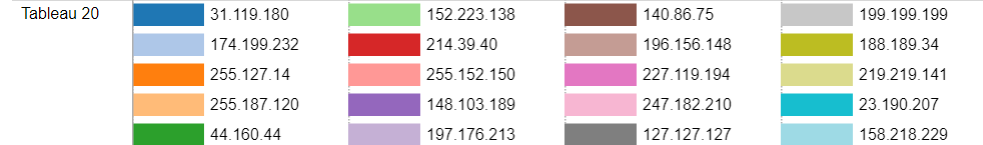

Let us understand the effect of different types of AlertName against the different column names. Here we will only be looking at "Alert" and "Warning" cases.

### Type of AlertName vs Group Name

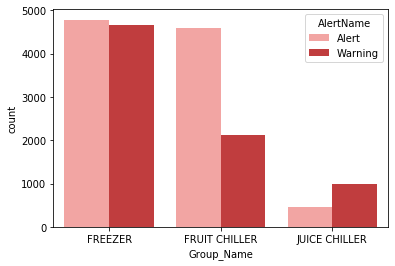

In [15]:
sns.countplot(df_combo['Group_Name'],hue=df_combo['AlertName'],palette=[tableau20[7],tableau20[6]])

Highest Alert and warning cases are in Freezer and Fruit Chiller and least is in Juice chiller.

### Type of AlertName vs Storage Name

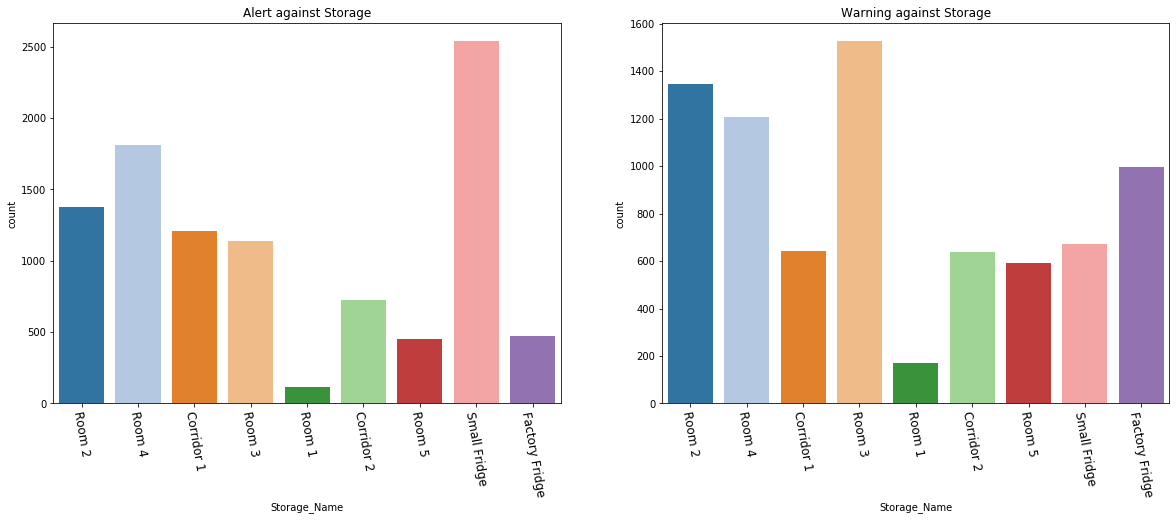

In [16]:
plt.figure(figsize=(20,7))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)

sns.countplot(df_alert['Storage_Name'],ax=ax1,palette=[tableau20[0],tableau20[1],tableau20[2],tableau20[3],tableau20[4],tableau20[5],tableau20[6],tableau20[7],tableau20[8]])
_=ax1.set_xticklabels(ax1.get_xticklabels(),rotation=-80,fontsize=12)                                                                            
ax1.set_title("Alert against Storage")

sns.countplot(df_warning['Storage_Name'],ax=ax2,palette=[tableau20[0],tableau20[1],tableau20[2],tableau20[3],tableau20[4],tableau20[5],tableau20[6],tableau20[7],tableau20[8]])
_=ax2.set_xticklabels(ax2.get_xticklabels(),rotation=-80,fontsize=12)
ax2.set_title("Warning against Storage")
plt.show()

- Highest alert level cases are in Small Fridge, Room 4 and Room 2
- Highest warning level cases are in Room 3, Room 2 and Room 4

### Type of AlertName vs Location Name

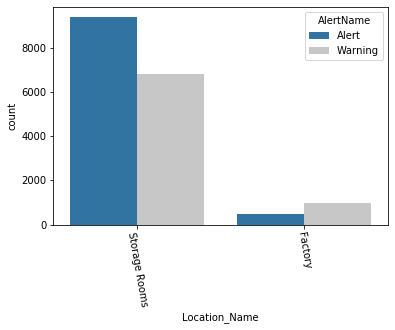

In [17]:
ax=sns.countplot(df_combo['Location_Name'],hue=df_combo['AlertName'],palette=[tableau20[0],tableau20[15]])
_=ax.set_xticklabels(ax.get_xticklabels(),rotation=-80)

Most of the Alerts and warnings happen in Storage Rooms

### Type of AlertName vs Service Name

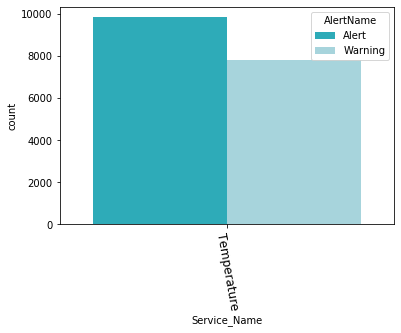

In [18]:
ax=sns.countplot(df_combo['Service_Name'],hue=df_combo['AlertName'],palette=[tableau20[18],tableau20[19]])
_=ax.set_xticklabels(ax.get_xticklabels(),rotation=-80,fontsize=12)

All of the alert and warning cases were caused due to breach in optimum temperature levels.

### Type of AlertName vs Device Name

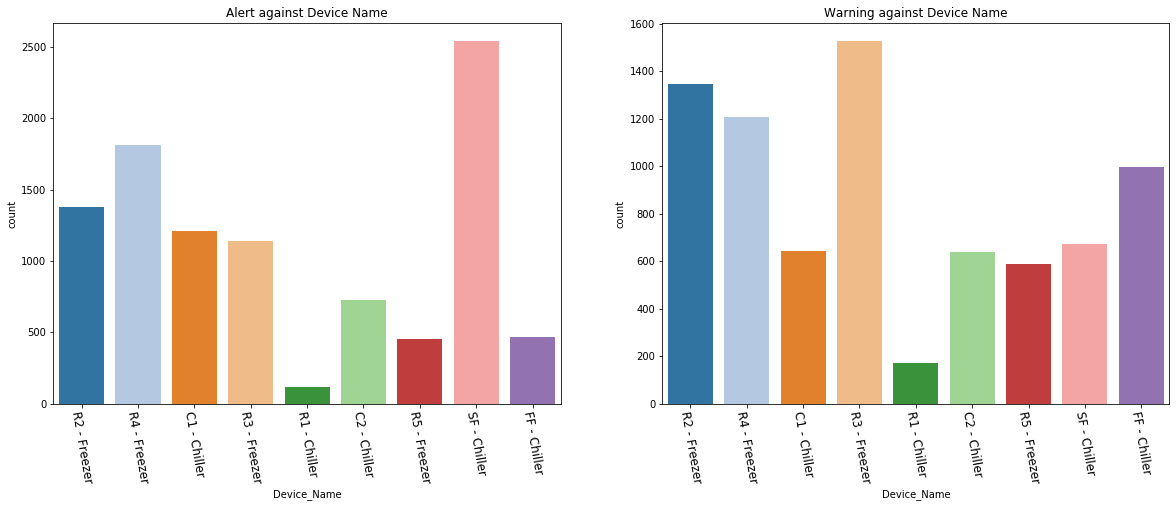

In [19]:
plt.figure(figsize=(20,7))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)

sns.countplot(df_alert['Device_Name'],ax=ax1,palette=[tableau20[0],tableau20[1],tableau20[2],tableau20[3],tableau20[4],tableau20[5],tableau20[6],tableau20[7],tableau20[8]])
_=ax1.set_xticklabels(ax1.get_xticklabels(),rotation=-80,fontsize=12)
ax1.set_title("Alert against Device Name")

sns.countplot(df_warning['Device_Name'],ax=ax2,palette=[tableau20[0],tableau20[1],tableau20[2],tableau20[3],tableau20[4],tableau20[5],tableau20[6],tableau20[7],tableau20[8]])
_=ax2.set_xticklabels(ax2.get_xticklabels(),rotation=-80,fontsize=12)
ax2.set_title("Warning against Device Name")
plt.show()

- Maximum alert cases are from SF-Chiller, R4-Freezer and R2-Freezer.
- Maximum warning cases are from R3-Freezer, R2-Freezer and R4-Freezer.

### Type of AlertName vs Hour

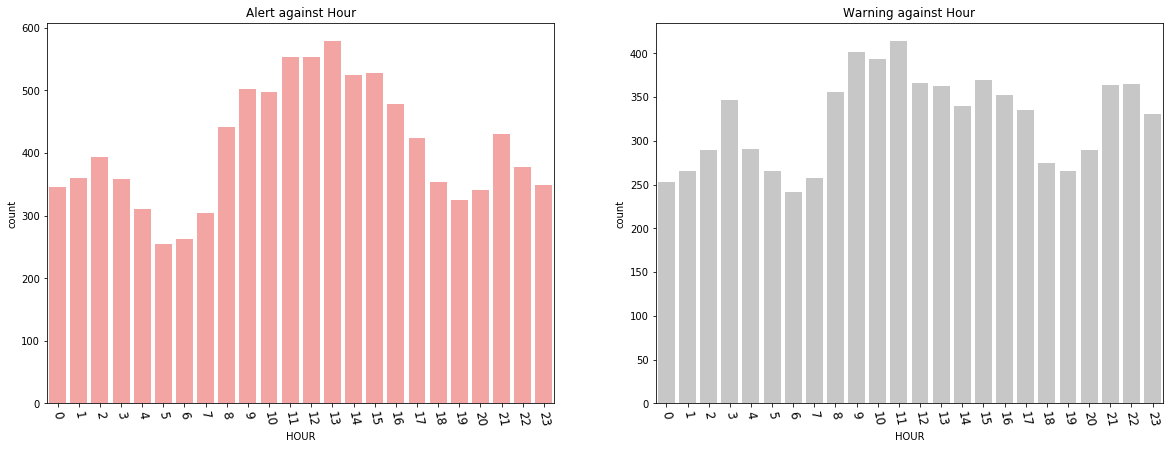

In [20]:
plt.figure(figsize=(20,7))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)

sns.countplot(df_alert['HOUR'],ax=ax1,palette=[tableau20[7]])
_=ax1.set_xticklabels(ax1.get_xticklabels(),rotation=-80,fontsize=12)
ax1.set_title("Alert against Hour")

sns.countplot(df_warning['HOUR'],ax=ax2,palette=[tableau20[15]])
_=ax2.set_xticklabels(ax2.get_xticklabels(),rotation=-80,fontsize=12)
ax2.set_title("Warning against Hour")
plt.show()

- So the highest alert cases are during the 11 AM to 4 PM.
- Highest warning cases are during 9-11 AM and then 9-10 PM.

### Type of AlertName vs NightTime

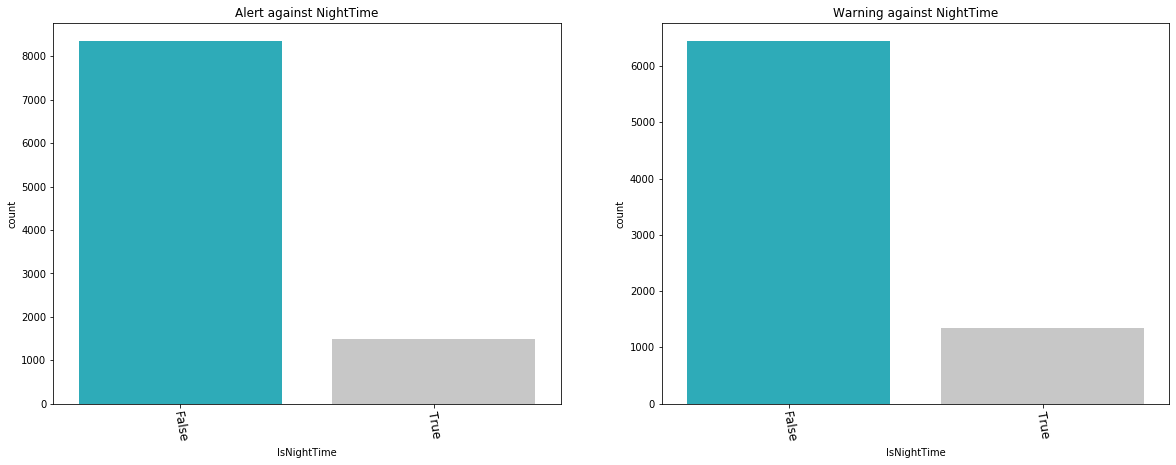

In [21]:
plt.figure(figsize=(20,7))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)

sns.countplot(df_alert['IsNightTime'],ax=ax1,palette=[tableau20[18],tableau20[15]])
_=ax1.set_xticklabels(ax1.get_xticklabels(),rotation=-80,fontsize=12)
ax1.set_title("Alert against NightTime")

sns.countplot(df_warning['IsNightTime'],ax=ax2,palette=[tableau20[18],tableau20[15]])
_=ax2.set_xticklabels(ax2.get_xticklabels(),rotation=-80,fontsize=12)
ax2.set_title("Warning against NightTime")
plt.show()

Majority of the alert and warning cases were during the day.

### Type of AlertName vs Month

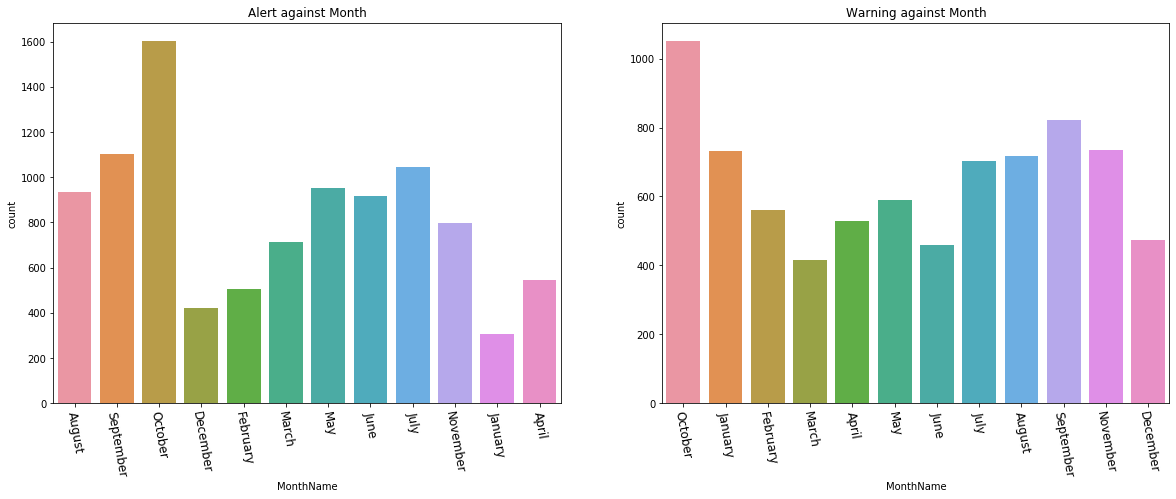

In [22]:
plt.figure(figsize=(20,7))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)

sns.countplot(df_alert['MonthName'],ax=ax1)
_=ax1.set_xticklabels(ax1.get_xticklabels(),rotation=-80,fontsize=12)
ax1.set_title("Alert against Month")

sns.countplot(df_warning['MonthName'],ax=ax2)
_=ax2.set_xticklabels(ax2.get_xticklabels(),rotation=-80,fontsize=12)
ax2.set_title("Warning against Month")
plt.show()

- Highest alert cases are in October and September. 
- Highest warning cases are also in October then January.

### Type of AlertName vs Year

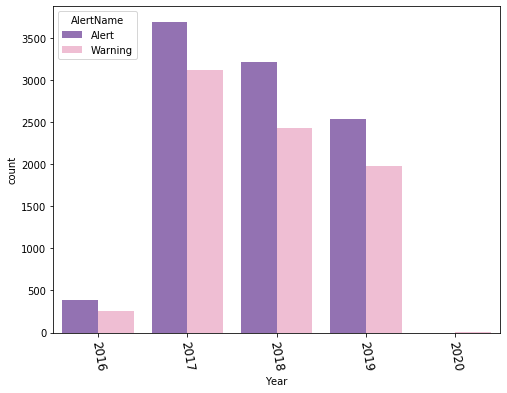

In [23]:
plt.figure(figsize=(8,6))
ax=sns.countplot(df_combo['Year'],hue=df_combo['AlertName'],palette=[tableau20[8],tableau20[13]])
_=ax.set_xticklabels(ax.get_xticklabels(),rotation=-80,fontsize=12)

Highest alert and warning cases were in 2017 and from that time onwards it has been decreasing which is good.

### Type of AlertName vs Day

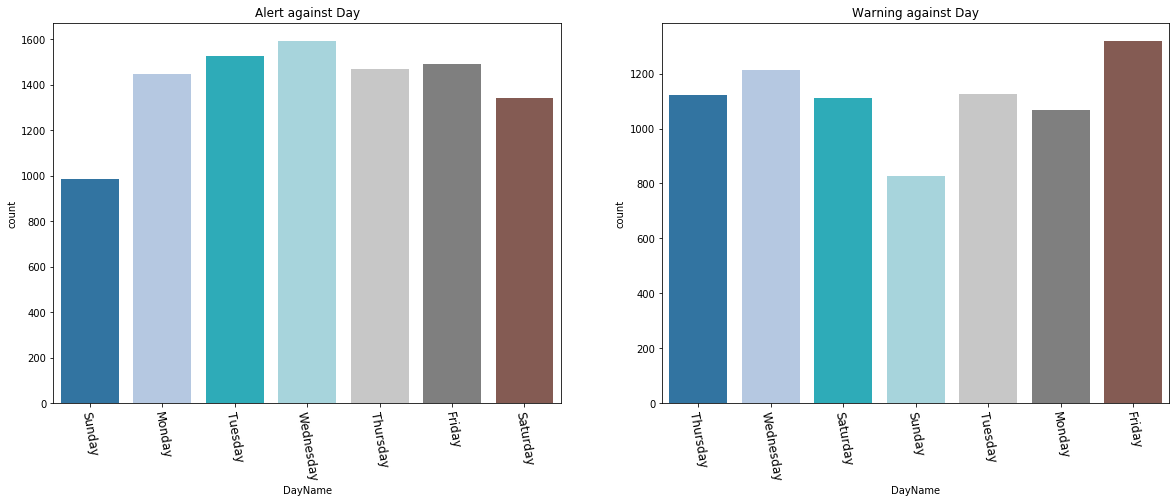

In [24]:
plt.figure(figsize=(20,7))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)

sns.countplot(df_alert['DayName'],ax=ax1,palette=[tableau20[0],tableau20[1],tableau20[18],tableau20[19],tableau20[15],tableau20[14],tableau20[10]],
             order=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'])
_=ax1.set_xticklabels(ax1.get_xticklabels(),rotation=-80,fontsize=12)
ax1.set_title("Alert against Day")

sns.countplot(df_warning['DayName'],ax=ax2,palette=[tableau20[0],tableau20[1],tableau20[18],tableau20[19],tableau20[15],tableau20[14],tableau20[10]])
_=ax2.set_xticklabels(ax2.get_xticklabels(),rotation=-80,fontsize=12)
ax2.set_title("Warning against Day")
plt.show()

- Highest alert cases were on Wednesdays, Fridays and Tuesdays and lowest on Sundays.
- Highest warning cases were on Fridays and Wednesdays and again lowest on Sundays.

### Type of AlertName vs Week of Month

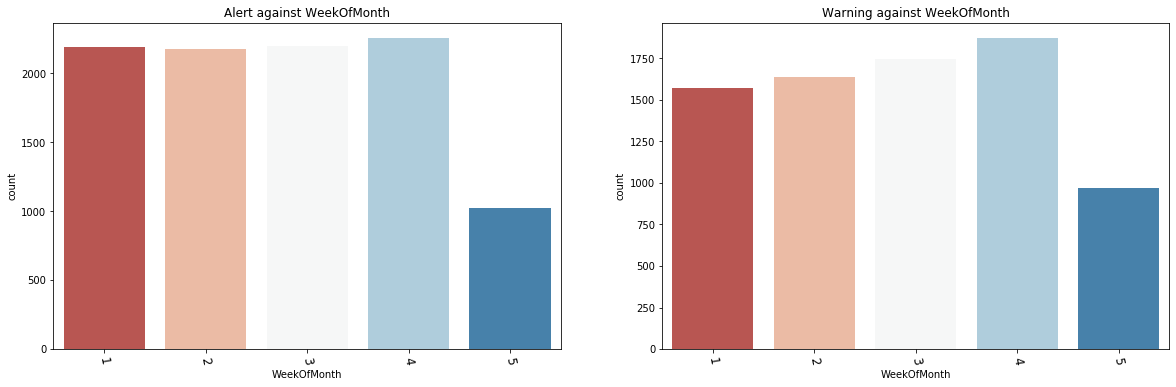

In [25]:
plt.figure(figsize=(20,6))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)

sns.countplot(df_alert['WeekOfMonth'],ax=ax1,palette="RdBu")
_=ax1.set_xticklabels(ax1.get_xticklabels(),rotation=-80,fontsize=12)
ax1.set_title("Alert against WeekOfMonth")

sns.countplot(df_warning['WeekOfMonth'],ax=ax2,palette="RdBu")
_=ax2.set_xticklabels(ax2.get_xticklabels(),rotation=-80,fontsize=12)
ax2.set_title("Warning against WeekOfMonth")
plt.show()

- Alert Cases are almost constant throughout a month but towards the end of the month the alert cases drop.
- Warning Cases are lesser during the 1st week then start increasing but towards the end of the month the alert cases drop.

### Type of AlertName vs Quarter

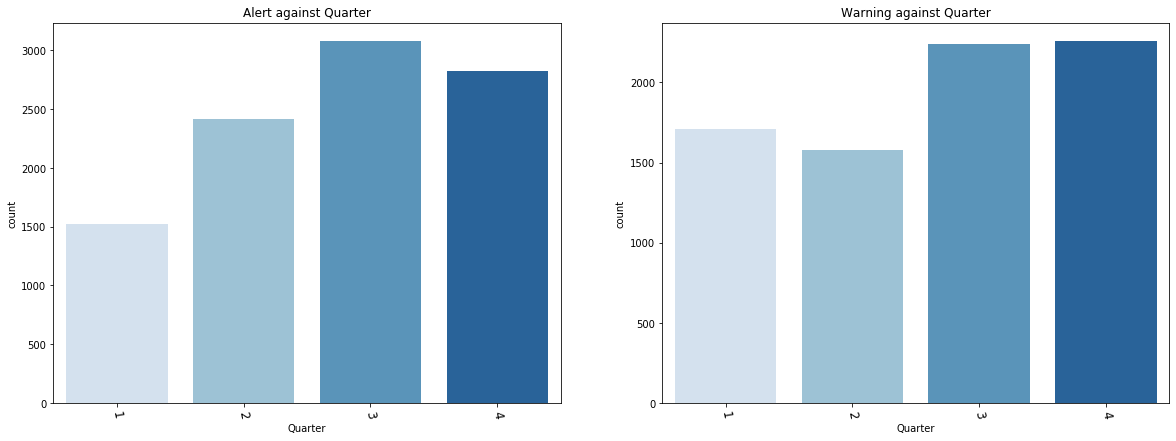

In [26]:
plt.figure(figsize=(20,7))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)

sns.countplot(df_alert['Quarter'],ax=ax1,palette="Blues")
_=ax1.set_xticklabels(ax1.get_xticklabels(),rotation=-80,fontsize=12)
ax1.set_title("Alert against Quarter")

sns.countplot(df_warning['Quarter'],ax=ax2,palette="Blues")
_=ax2.set_xticklabels(ax2.get_xticklabels(),rotation=-80,fontsize=12)
ax2.set_title("Warning against Quarter")
plt.show()

So alert and warning cases are lesser during the beginning of the year i.e first quarter and most during the 3rd quarter.

### Type of AlertName vs WeekDay

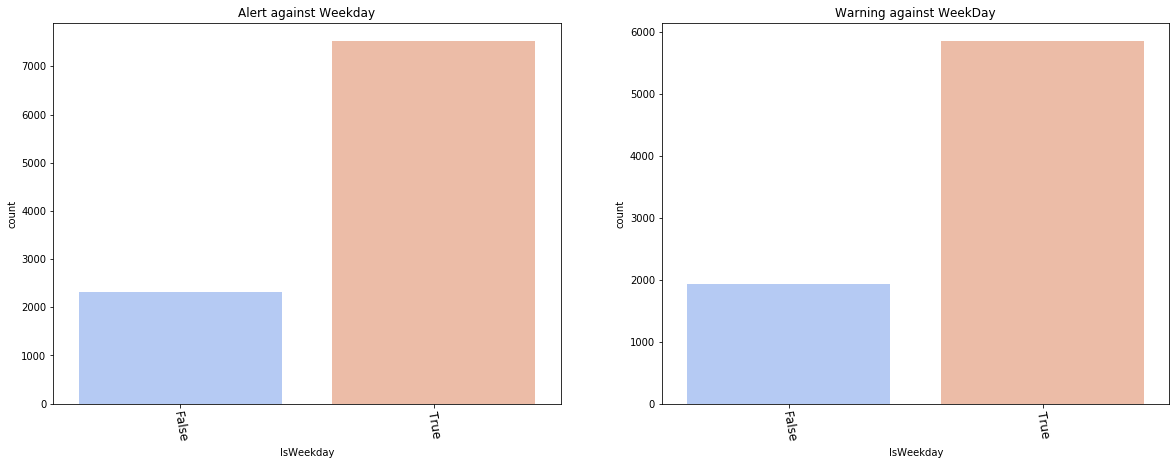

In [27]:
plt.figure(figsize=(20,7))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)

sns.countplot(df_alert['IsWeekday'],ax=ax1,palette="coolwarm")
_=ax1.set_xticklabels(ax1.get_xticklabels(),rotation=-80,fontsize=12)
ax1.set_title("Alert against Weekday")

sns.countplot(df_warning['IsWeekday'],ax=ax2,palette="coolwarm")
_=ax2.set_xticklabels(ax2.get_xticklabels(),rotation=-80,fontsize=12)
ax2.set_title("Warning against WeekDay")
plt.show()

Most of the alert and warning cases are on a weekday.

### Distribution of "Value" for Alert Cases

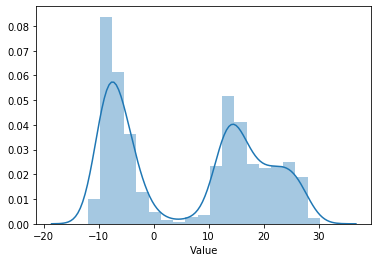

In [28]:
sns.distplot(df_alert['Value'])

In [29]:
df_alert['Value'].value_counts()

-9.900000     123
-9.400000     118
-9.000000     114
-9.300000     114
-8.100000     107
             ... 
 9.000000       1
 0.500000       1
 30.100000      1
 2.700000       1
 29.799999      1
Name: Value, Length: 370, dtype: int64

So maximum alert level cases happen when value is -9.9 and -9.6. Let's understand what these parameters are actually.

### Alert Cases where Value = -9.9

In [30]:
df_alert[df_alert['Value']== (df_alert['Value'].value_counts().index[0])]['Service_Name'].value_counts() 

Temperature    123
Name: Service_Name, dtype: int64

In [31]:
df_alert[df_alert['Value']==(df_alert['Value'].value_counts().index[0])]['Group_Name'].value_counts(normalize=True)

FREEZER    1.0
Name: Group_Name, dtype: float64

So 100% of the alert cases where value is -9.9 happens in Freezer.

In [32]:
df_alert[df_alert['Value']==(df_alert['Value'].value_counts().index[0])]['Storage_Name'].value_counts(normalize=True)

Room 3    0.430894
Room 2    0.260163
Room 4    0.227642
Room 5    0.081301
Name: Storage_Name, dtype: float64

The alert cases wih value = -9.9 is almost equally divided among rooms 4 and 3.

In [33]:
df_alert[df_alert['Value']==(df_alert['Value'].value_counts().index[0])]['Location_Name'].value_counts(normalize=True)

Storage Rooms    1.0
Name: Location_Name, dtype: float64

All of the alert cases with value = -9.9 are in storage rooms.

<b>Summary:</b> All of the alert cases with values of -9.9 happend in the freezer which is in the storage room and the -9.9 indicates the temperature which means the optimal temp. was not being met.

### Alert values for each Device

Let us understand at what value do we get maximum alert cases for each device.

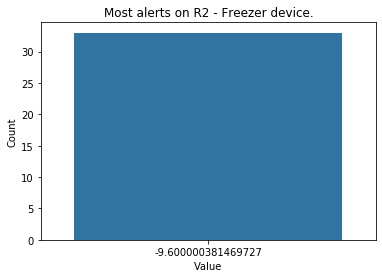

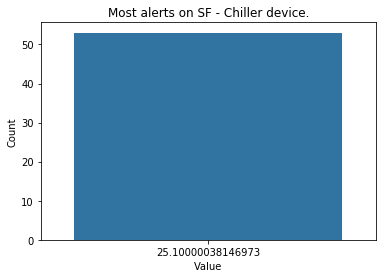

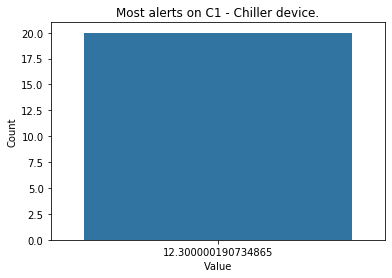

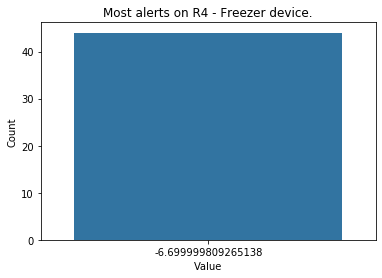

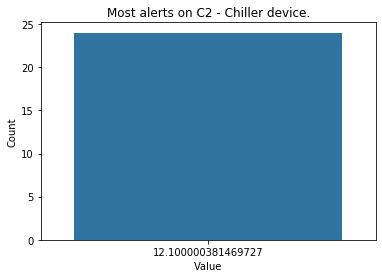

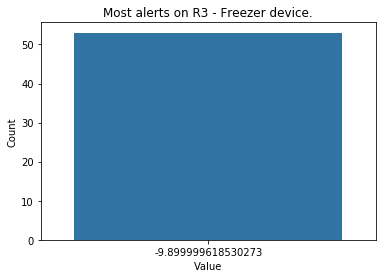

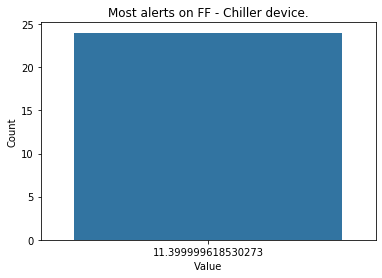

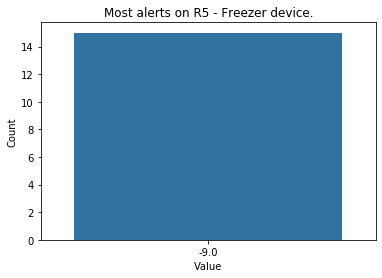

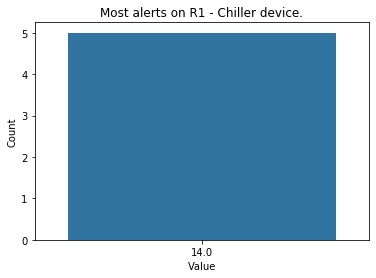

In [34]:
dsv=pd.DataFrame(df_alert.groupby(['Device_Name','Service_Name','Value']).count()['AlertName'])
dsv.reset_index(inplace=True)
dsv.rename(columns={'AlertName':'Count'},inplace=True)

#for device,service,value,count in zip(dsv['Device_Name'],dsv['Service_Name'],dsv['Value'],dsv['Count']):
    #dsv=dsv.sort_values()

df_dummy=[]
#plt.figure(figsize=(20,10))
#ax1=plt.subplot(3,3,1)
#ax2=plt.subplot(3,3,2)
#ax3=plt.subplot(3,3,3)
#ax4=plt.subplot(3,3,4)
#ax5=plt.subplot(3,3,5)
#ax6=plt.subplot(3,3,6)
#ax7=plt.subplot(3,3,7)
#ax8=plt.subplot(3,3,8)
#ax9=plt.subplot(3,3,9)

for index,device in enumerate(dsv['Device_Name'].value_counts().index):
    d=[]
    dummy=dsv[dsv['Device_Name']==device]
    dummy=dummy.sort_values(by=["Device_Name","Count"])
    d.append(dummy.iloc[-1])
    df=pd.DataFrame(d)
    sns.barplot(x=df['Value'],y=df['Count'])
    plt.title("Most alerts on {} device.".format(device))
    plt.show()

#### [Click here to go to the table of contents](#TOC) 

### Part 2 - Logistic Regression <a id='logregr'></a>

<img src="https://blog.advids.co/wp-content/uploads//2017/09/Google-Analytics11.gif" width="400" align="center">

One of the short comings I noticed from the dataset was that we are able to identify an alert case only after an alert case occurs. However, with machine learning algorithms you can predict if a case will be an alert case or not based on certain input parameters. This approach will help organizations shift from the mindset of analyzing past data to understand what happened and why it happened to a more sophisticated and forward-thinking mindset where we can predict what will happen? This will help organizations identify any threats beforehand. 

In order to achieve this, I have used logistic regression to classify the cases as Alert case (1) or not an alert case (0). The model is able to predict whether a case will be an alert or not and it will also tell us the probability of a case being an alert case with a 97% accuracy.


In [35]:
df_reading.head()

,Value,AlertName,Date,Time,DATETIME,DayOfMonth,DayName,DayOfWeek,WeekOfMonth,Month,...,Location_Name,Latitude,Longitude,MinName,MinValue,MaxName,MaxValue,AlertValue,AlertFunction,Service_Name
0,25.500000,Alert,2016-08-26,19:00:00,2016-08-26 19:00:00.200,26,Friday,6,4,8,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature
1,26.299999,Alert,2016-08-26,19:45:00,2016-08-26 19:45:00.200,26,Friday,6,4,8,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature
2,27.299999,Alert,2016-08-26,22:15:00,2016-08-26 22:15:00.200,26,Friday,6,4,8,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature
3,27.500000,Alert,2016-08-27,00:30:00,2016-08-27 00:30:00.200,27,Saturday,7,4,8,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature
4,27.600000,Alert,2016-08-27,02:00:00,2016-08-27 02:00:00.200,27,Saturday,7,4,8,...,Storage Rooms,24.991264,55.103042,Minimum Temparature,-22,Maximum Temperature,-14,-10,>,Temperature


In [36]:
df_reading.columns

Index(['Value', 'AlertName', 'Date', 'Time', 'DATETIME', 'DayOfMonth',
       'DayName', 'DayOfWeek', 'WeekOfMonth', 'Month', 'MonthName', 'Quarter',
       'QuarterName', 'Year', 'IsWeekday', 'HOUR', 'IsNightTime',
       'Device_Name', 'Group_Name', 'Storage_Name', 'Location_Name',
       'Latitude', 'Longitude', 'MinName', 'MinValue', 'MaxName', 'MaxValue',
       'AlertValue', 'AlertFunction', 'Service_Name'],
      dtype='object')

<b>Dependant features:</b>
1. Value
2. Day of Month
3. Day of Week
4. Week of Month 
5. Month
6. Quarter
7. Year
8. IsWeekday
9. Hour
10. IsNightTime
11. Group Name
12. Storage Name
13. Location Name
14. Latitude
15. Longitude
16. Service Name

<b>Independant feature:</b> Alert Name

Our model will use the above features to classifiy the cases as Alert(1) or not(0) and we will cross check if the model predicted it correctly.

In [37]:
df_regr=df_reading[['Value','DayOfMonth',
                    'DayOfWeek', 'WeekOfMonth', 'Month', 'Quarter',
                    'Year', 'IsWeekday', 'HOUR', 'IsNightTime',
                    'Group_Name', 'Storage_Name', 'Location_Name',
                    'Latitude', 'Longitude', 'Service_Name','AlertName']]

In [38]:
df_regr.head()

,Value,DayOfMonth,DayOfWeek,WeekOfMonth,Month,Quarter,Year,IsWeekday,HOUR,IsNightTime,Group_Name,Storage_Name,Location_Name,Latitude,Longitude,Service_Name,AlertName
0,25.500000,26,6,4,8,3,2016,True,19,False,FREEZER,Room 2,Storage Rooms,24.991264,55.103042,Temperature,Alert
1,26.299999,26,6,4,8,3,2016,True,19,False,FREEZER,Room 2,Storage Rooms,24.991264,55.103042,Temperature,Alert
2,27.299999,26,6,4,8,3,2016,True,22,True,FREEZER,Room 2,Storage Rooms,24.991264,55.103042,Temperature,Alert
3,27.500000,27,7,4,8,3,2016,False,0,False,FREEZER,Room 2,Storage Rooms,24.991264,55.103042,Temperature,Alert
4,27.600000,27,7,4,8,3,2016,False,2,False,FREEZER,Room 2,Storage Rooms,24.991264,55.103042,Temperature,Alert


Let us convert the "IsNightTime","IsWeekday" and "AlertName" columns to numerical values so that we can use logistic regression on it.

In [39]:
df_regr['IsNightTime']=df_regr['IsNightTime'].apply(lambda x : 1 if x ==True else 0)
df_regr['IsWeekday']=df_regr['IsWeekday'].apply(lambda x : 1 if x ==True else 0)
df_regr['AlertName']=df_regr['AlertName'].apply(lambda x : 1 if x == "Alert" else 0)

c:\users\aasth\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\aasth\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\aasth\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [40]:
df_regr.head()

,Value,DayOfMonth,DayOfWeek,WeekOfMonth,Month,Quarter,Year,IsWeekday,HOUR,IsNightTime,Group_Name,Storage_Name,Location_Name,Latitude,Longitude,Service_Name,AlertName
0,25.500000,26,6,4,8,3,2016,1,19,0,FREEZER,Room 2,Storage Rooms,24.991264,55.103042,Temperature,1
1,26.299999,26,6,4,8,3,2016,1,19,0,FREEZER,Room 2,Storage Rooms,24.991264,55.103042,Temperature,1
2,27.299999,26,6,4,8,3,2016,1,22,1,FREEZER,Room 2,Storage Rooms,24.991264,55.103042,Temperature,1
3,27.500000,27,7,4,8,3,2016,0,0,0,FREEZER,Room 2,Storage Rooms,24.991264,55.103042,Temperature,1
4,27.600000,27,7,4,8,3,2016,0,2,0,FREEZER,Room 2,Storage Rooms,24.991264,55.103042,Temperature,1


We will have to convert all the categorical columns to numerical values in order for our model to work. We will be using One Hot Encoding to do the same.

In [42]:
for col in ["Group_Name","Storage_Name","Location_Name","Service_Name"]:
    cat_list = pd.get_dummies(df_regr[col],prefix=col)
    df_regr1=df_regr.join(cat_list)
    df_regr=df_regr1

In [43]:
df_regr

,Value,DayOfMonth,DayOfWeek,WeekOfMonth,Month,Quarter,Year,IsWeekday,HOUR,IsNightTime,...,Storage_Name_Room 2,Storage_Name_Room 3,Storage_Name_Room 4,Storage_Name_Room 5,Storage_Name_Small Fridge,Storage_Name_Warehouse Fridge,Location_Name_Factory,Location_Name_Jnah Warehouse,Location_Name_Storage Rooms,Service_Name_Temperature
0,25.500000,26,6,4,8,3,2016,1,19,0,...,1,0,0,0,0,0,0,0,1,1
1,26.299999,26,6,4,8,3,2016,1,19,0,...,1,0,0,0,0,0,0,0,1,1
2,27.299999,26,6,4,8,3,2016,1,22,1,...,1,0,0,0,0,0,0,0,1,1
3,27.500000,27,7,4,8,3,2016,0,0,0,...,1,0,0,0,0,0,0,0,1,1
4,27.600000,27,7,4,8,3,2016,0,2,0,...,1,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63465,1.700000,3,2,1,12,4,2018,1,6,0,...,0,0,0,0,0,0,1,0,0,1
63466,3.900000,3,2,1,12,4,2018,1,10,0,...,0,0,0,0,0,0,1,0,0,1
63467,2.800000,28,3,4,11,4,2017,1,5,0,...,0,0,0,0,0,1,0,1,0,1
63468,-1.100000,28,3,4,11,4,2017,1,6,0,...,0,0,0,0,0,1,0,1,0,1


In [44]:
df_regr.columns

Index(['Value', 'DayOfMonth', 'DayOfWeek', 'WeekOfMonth', 'Month', 'Quarter',
       'Year', 'IsWeekday', 'HOUR', 'IsNightTime', 'Group_Name',
       'Storage_Name', 'Location_Name', 'Latitude', 'Longitude',
       'Service_Name', 'AlertName', 'Group_Name_FREEZER',
       'Group_Name_FRUIT CHILLER', 'Group_Name_JUICE CHILLER',
       'Storage_Name_Corridor 1', 'Storage_Name_Corridor 2',
       'Storage_Name_Factory Fridge', 'Storage_Name_Room 1',
       'Storage_Name_Room 2', 'Storage_Name_Room 3', 'Storage_Name_Room 4',
       'Storage_Name_Room 5', 'Storage_Name_Small Fridge',
       'Storage_Name_Warehouse Fridge', 'Location_Name_Factory',
       'Location_Name_Jnah Warehouse', 'Location_Name_Storage Rooms',
       'Service_Name_Temperature'],
      dtype='object')

In [45]:
#df_regr.drop(['Group_Name',
       #'Storage_Name', 'Location_Name','Factory', 'Jnah Warehouse',
       #'Storage Rooms', 'FREEZER', 'FRUIT CHILLER', 'JUICE CHILLER',
       #'Corridor 1', 'Corridor 2', 'Factory Fridge', 'Room 1', 'Room 2',
       #'Room 3', 'Room 4', 'Room 5', 'Small Fridge', 'Warehouse Fridge'],axis=1,inplace=True)

In [46]:
#df_regr.drop("Service_Name",axis=1,inplace=True)

In [47]:
df_regr.columns

Index(['Value', 'DayOfMonth', 'DayOfWeek', 'WeekOfMonth', 'Month', 'Quarter',
       'Year', 'IsWeekday', 'HOUR', 'IsNightTime', 'Group_Name',
       'Storage_Name', 'Location_Name', 'Latitude', 'Longitude',
       'Service_Name', 'AlertName', 'Group_Name_FREEZER',
       'Group_Name_FRUIT CHILLER', 'Group_Name_JUICE CHILLER',
       'Storage_Name_Corridor 1', 'Storage_Name_Corridor 2',
       'Storage_Name_Factory Fridge', 'Storage_Name_Room 1',
       'Storage_Name_Room 2', 'Storage_Name_Room 3', 'Storage_Name_Room 4',
       'Storage_Name_Room 5', 'Storage_Name_Small Fridge',
       'Storage_Name_Warehouse Fridge', 'Location_Name_Factory',
       'Location_Name_Jnah Warehouse', 'Location_Name_Storage Rooms',
       'Service_Name_Temperature'],
      dtype='object')

Let's drop any unnecessary columns fromm df_regr before we train our dataset.

In [48]:
df_regr.drop(['Group_Name','Storage_Name', 'Location_Name'],axis=1,inplace=True)

In [49]:
df_regr.columns

Index(['Value', 'DayOfMonth', 'DayOfWeek', 'WeekOfMonth', 'Month', 'Quarter',
       'Year', 'IsWeekday', 'HOUR', 'IsNightTime', 'Latitude', 'Longitude',
       'Service_Name', 'AlertName', 'Group_Name_FREEZER',
       'Group_Name_FRUIT CHILLER', 'Group_Name_JUICE CHILLER',
       'Storage_Name_Corridor 1', 'Storage_Name_Corridor 2',
       'Storage_Name_Factory Fridge', 'Storage_Name_Room 1',
       'Storage_Name_Room 2', 'Storage_Name_Room 3', 'Storage_Name_Room 4',
       'Storage_Name_Room 5', 'Storage_Name_Small Fridge',
       'Storage_Name_Warehouse Fridge', 'Location_Name_Factory',
       'Location_Name_Jnah Warehouse', 'Location_Name_Storage Rooms',
       'Service_Name_Temperature'],
      dtype='object')

Let's define X and y for our dataset. X represents the dependant features we saw earlier and y represents the independant feature that we are trying to predict i.e. Alert (1) or not (0).

In [50]:
X=np.asarray(df_regr[['Value', 'DayOfMonth', 'DayOfWeek', 'WeekOfMonth', 'Month', 'Quarter',
       'Year', 'IsWeekday', 'HOUR', 'IsNightTime', 'Latitude', 'Longitude',
        'Group_Name_FREEZER', 'Group_Name_FRUIT CHILLER',
       'Group_Name_JUICE CHILLER', 'Storage_Name_Corridor 1',
       'Storage_Name_Corridor 2', 'Storage_Name_Factory Fridge',
       'Storage_Name_Room 1', 'Storage_Name_Room 2', 'Storage_Name_Room 3',
       'Storage_Name_Room 4', 'Storage_Name_Room 5',
       'Storage_Name_Small Fridge', 'Storage_Name_Warehouse Fridge',
       'Location_Name_Factory', 'Location_Name_Jnah Warehouse',
       'Location_Name_Storage Rooms', 'Service_Name_Temperature']])

In [51]:
y=np.asarray(df_regr['AlertName'])

Now let's normalize the dataset.

In [52]:
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

### Train/Test dataset

Our model will use the train set to learn the patterns in the data and we will use the test set to check the accuracy and performancy of the model.

In [53]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=4)
print("Train set shape:",X_train.shape,y_train.shape)
print("Train set shape:",X_test.shape,y_test.shape)

Train set shape: (50776, 29) (50776,)
Train set shape: (12694, 29) (12694,)


### Modeling

Finally, we can run our model on our train set.

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

Let us use our trained model to predict whether it is an alert or not and we will store it in a variable called "y_predicted"

In [55]:
y_predicted=LR.predict(X_test)

Let us also predict the probability of the case being an alert case. This can be done using predict_proba(). __predict_proba__  returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 0, P(Y=0|X), and second column is probability of class 1 i.e. Alert, P(Y=1|X):

In [56]:
y_predicted_prob = LR.predict_proba(X_test)
y_predicted_prob[:3]

array([[0.99346922, 0.00653078],
       [0.96829511, 0.03170489],
       [0.95350445, 0.04649555]])

### Evaluation

Now our model is ready. Let test the accuracy using 3 measures:
1. Jaccard Similarity
2. Confusion Matrix
3. Classification Report
4. Log loss

#### 1. Jaccard Similarity

If the entire set of predicted labels for a sample strictly match with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.


In [57]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, y_predicted)

c:\users\aasth\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.9671498345675122

#### 2. Confusion Matrix

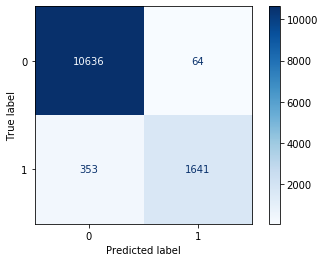

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(LR, X_test, y_test,values_format='d',cmap="Blues") 
plt.grid(False)
plt.show()  

#### 3. Classification Report

In [59]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     10700
           1       0.96      0.82      0.89      1994

    accuracy                           0.97     12694
   macro avg       0.97      0.91      0.93     12694
weighted avg       0.97      0.97      0.97     12694



Based on the count of each section, we can calculate precision and recall of each label:


- __Precision__ is a measure of the accuracy provided that a class label has been predicted. It is defined by: precision = TP / (TP + FP)

- __Recall__ is true positive rate. It is defined as: Recall =  TP / (TP + FN)

    
So, we can calculate precision and recall of each class.

__F1 score:__
Now we are in the position to calculate the F1 scores for each label based on the precision and recall of that label. 

The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.


And finally, we can tell the average accuracy for this classifier is the average of the F1-score for both labels, which is <b>0.97</b> in our case.

#### 4. Log Loss

Now, lets try __log loss__ for evaluation. In logistic regression, the output can be the probability of alert is yes (or equals to 1). This probability is a value between 0 and 1.
Log loss( Logarithmic loss) measures the performance of a classifier where the predicted output is a probability value between 0 and 1. Naturally, we want the log loss value to be less.

In [60]:
from sklearn.metrics import log_loss
log_loss(y_test, y_predicted_prob)

0.11446521994320594

### Results of Logistic Regression

Let's look at what our model predicted, what was the actual value and what was the probability of alert case as predicted by our model.

In [61]:
#list(y_test)
#list(y_predicted)

Actual=[]
Predicted=[]
Prob=[]

for index in range(0,len(y_test)):
    Actual.append(y_test[index])
    Predicted.append(y_predicted[index])
    Prob.append(round(y_predicted_prob[index,1]*100,2))

Result=pd.DataFrame(list(zip(Actual,Predicted,Prob)),columns=["Actual Value of Alert(1/0)","Predicted Value of Alert(1/0)","Probability of Alert(%)"])
Result.tail(10)

,Actual Value of Alert(1/0),Predicted Value of Alert(1/0),Probability of Alert(%)
12684,1,1,98.69
12685,0,0,1.20
12686,0,0,4.06
12687,0,0,0.13
12688,0,0,2.11
12689,0,0,0.84
12690,0,0,27.33
12691,0,0,2.98
12692,0,0,3.23
12693,0,0,0.61


As you can see in the above table at index 12684, our classifier correctly classified the alert as 1 and also said that there is a 98.69% chance of this case being an alert. When we look at the "Actual Value of Alert" column it turns out that it was actually an alert.

So our classifier can classify a cases as Alert(1) or not an Alert level case(0) and even tell the probability of being an alert case with an accuracy of <b>97%</b>.

#### [Click here to go to the table of contents](#TOC) 

## Part 3 - Sending Alert cases on whatsapp <a id='whatsapp'></a>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6b/WhatsApp.svg/1200px-WhatsApp.svg.png" width="200">

One of the key problems that was mentioned in the Livestream of the Hackathon [(Click here for Livestream)](https://www.youtube.com/watch?v=wdKCSeZvRqE) was that the engineers are the ones who monitor the cases and most of the times they do not realize which case needs urgent attention as they are not subject matter experts when it comes to food health and safety. In order to make this process efficient, I thought it would be helpful if the Health & Safety executive was able to get the alert cases on WhatsApp so we can reduce any latency.

Hence, we will now send the cases where our classifier has predicted an alert along with the probability % of that case being an alert case. 

Of course we can modify this further and refine our results , for example, we can only send notifications to the health manager when the probability is more than 50%. However, for this project let's try to send the notification only when the probability % is 90%+.

I have used the Twilio API for this project. You can read more information here -[Twilio Doc](https://www.twilio.com/docs/whatsapp/quickstart/python#whatsapp-beta-1)

Let us first look at how many cases have a probability of 90% +.

In [63]:
Result[Result["Probability of Alert(%)"]>=90]

,Actual Value of Alert(1/0),Predicted Value of Alert(1/0),Probability of Alert(%)
15,1,1,99.49
40,1,1,92.30
58,1,1,98.20
65,1,1,98.34
82,1,1,91.43
...,...,...,...
12552,1,1,95.04
12576,1,1,99.77
12581,1,1,97.52
12656,1,1,91.06


Now since I will be putting my number here just to test and I don't want to receive 694 notifications, I will only be sending the notifications where the probability % is 100% however as mentioned earlier this can be tweaked according to the client requirement.

In [64]:
df_100=Result[Result["Probability of Alert(%)"]>=100]
df_100

,Actual Value of Alert(1/0),Predicted Value of Alert(1/0),Probability of Alert(%)
1548,1,1,100.0
1828,1,1,100.0
2933,1,1,100.0
3457,1,1,100.0
5467,1,1,100.0
5634,1,1,100.0
6102,1,1,100.0
6699,1,1,100.0
6765,1,1,100.0
8229,1,1,100.0


In [65]:
len(Result[Result["Probability of Alert(%)"]>=100])

13

Okay so we have 13 cases where the probability of that case being an alert is 100%. Let's send this over as notifications on whatsapp so immediate action can be taken BEFORE an actual alert is raised.

In [66]:
!pip install twilio

In [67]:
# Download the helper library from https://www.twilio.com/docs/python/install
from twilio.rest import Client


# Your Account Sid and Auth Token from twilio.com/console
# DANGER! This is insecure. See http://twil.io/secure
account_sid = <SID>
auth_token = <token>
client = Client(account_sid, auth_token)

message = client.messages.create(
                              body= "Cases with index number {} have a 100% probability of being an alert case".format(",".join(str(item) for item in list(df_100.index))),   
                              #body="Hello",
                              from_='whatsapp: twilio number',
                              to='whatsapp: your number'
                          )

#print(message.sid)

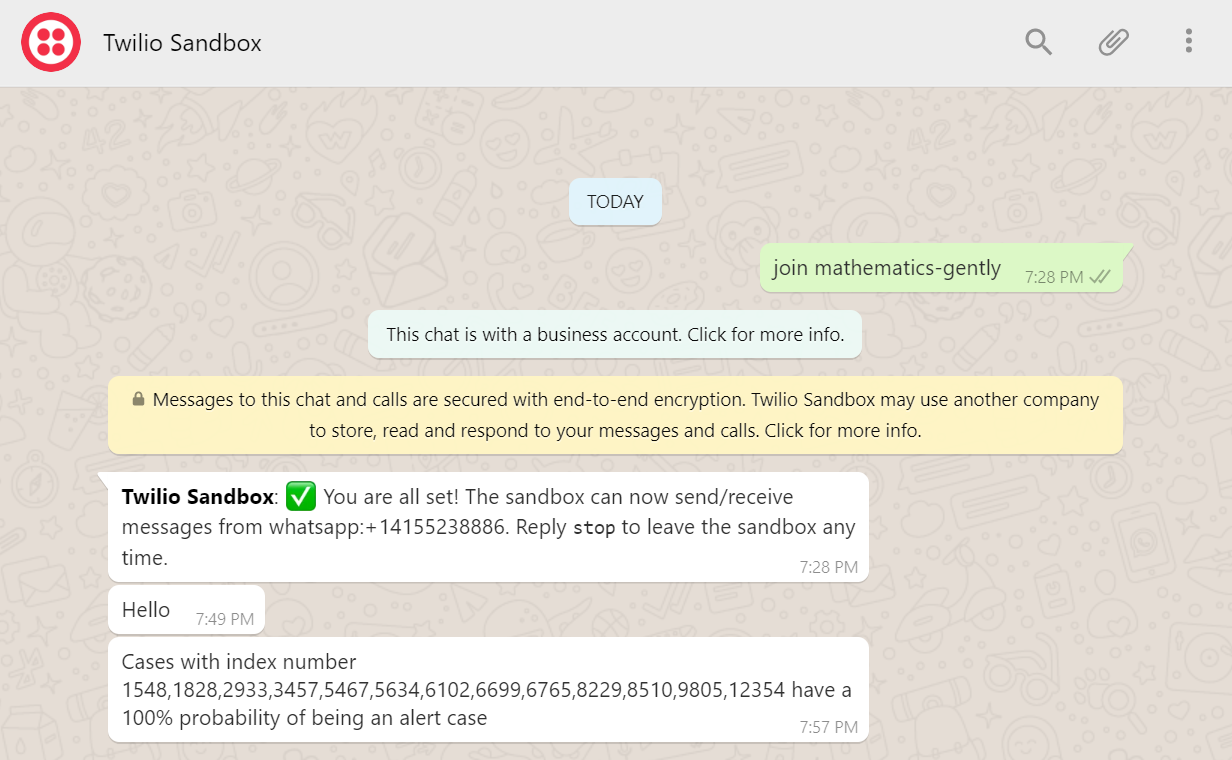

Yay this works! We can of course tweek the message however we want to incorporate more details.

I tried sending the dataframe df1_100 as an image on whatsapp to improve readability however Twilio only allows to send media messages/URLs that are publicly available.
Check link here for more information: [Twilio Documentation](https://www.twilio.com/docs/whatsapp/tutorial/send-and-receive-media-messages-whatsapp-python)

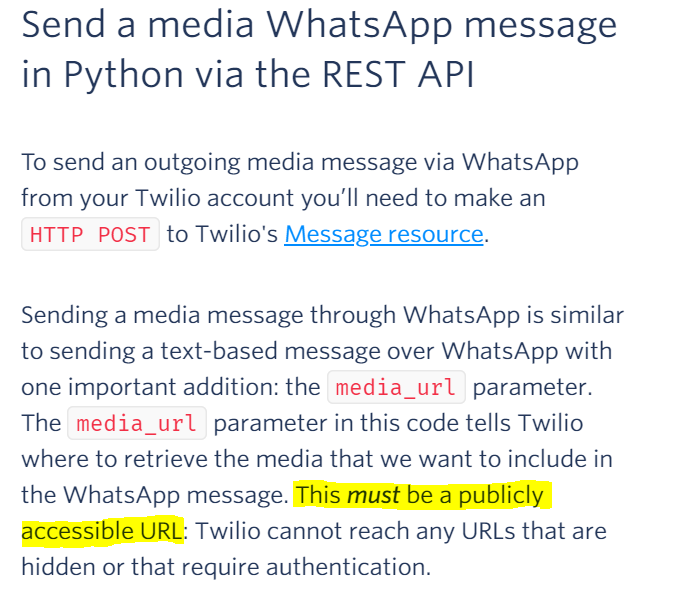

#### [Click here to go to the table of contents](#TOC) 

## Part 4 - Deploying the model to a web app <a id='web'></a>

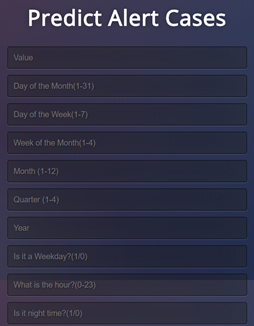

I'll be using "pickle" to store the trained model so we don't have to manually train it every time. For more information on how to deploy a ML model to the web, you can check out this link: [Source Link](https://blog.cambridgespark.com/deploying-a-machine-learning-model-to-the-web-725688b851c7)

In [109]:
!pip install flask

In [112]:
import pickle
with open('MDX Hackathon.pkl', 'wb') as file:
    pickle.dump(LR, file)

### Creating web app with Flask

Okay now we will create a separate python file called "app" where we will take in the inputs from the user and run our model to predict the results.

We will also need to write a few lines in css and html. 

All of the above files need to be saved in the same directory and using Heroku we will deploy our website.

### Link to see Final web app: https://alert-model.herokuapp.com/

#### [Click here to go to the table of contents](#TOC) 

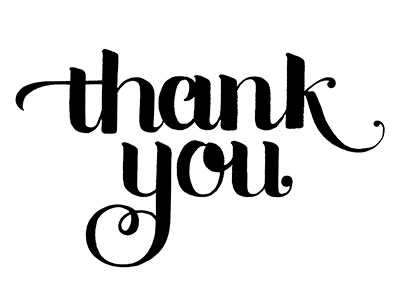